In [1]:
import pandas as pd
import tensorflow
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation,Conv2D,Reshape
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import *
import math
import time
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/2330.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,SMA5,SMA10,SMA20,SMA60,Vol,MA5,MA10,DIF,MACD9,OSC,K,D
0,2011/7/20,69.7,71.7,69.4,71.6,70.08,70.83,71.79,74.02,58272,59446,55917,-1.15,-1.00,-0.15,32.35%,26.05%
1,2011/7/21,71.4,71.6,70.6,71.6,70.26,70.83,71.66,74.05,33277,55219,54470,-1.04,-1.01,-0.03,46.77%,32.96%
2,2011/7/22,72.4,72.4,71.7,72.0,70.68,70.78,71.62,74.04,38244,45044,52998,-0.88,-0.98,0.10,60.35%,42.09%
3,2011/7/25,72.4,72.5,71.4,72.0,71.14,70.85,71.62,74.02,34963,44443,51283,-0.76,-0.94,0.18,69.40%,51.19%
4,2011/7/26,72.3,73.7,72.3,73.7,72.18,71.19,71.68,74.03,53159,43583,52599,-0.54,-0.86,0.32,79.60%,60.66%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 17 columns):
Date     1661 non-null object
Open     1661 non-null float64
High     1661 non-null float64
Low      1661 non-null float64
Close    1661 non-null float64
SMA5     1661 non-null float64
SMA10    1661 non-null float64
SMA20    1661 non-null float64
SMA60    1661 non-null float64
Vol      1661 non-null int64
MA5      1661 non-null int64
MA10     1661 non-null int64
DIF      1661 non-null float64
MACD9    1661 non-null float64
OSC      1661 non-null float64
K        1661 non-null object
D        1661 non-null object
dtypes: float64(11), int64(3), object(3)
memory usage: 220.7+ KB


In [5]:
def batch_data(time_steps,sd,batch_size,predmon,n_batch):

    df = pd.read_csv('data/2330.csv')

    del df['Date']

    del df['DIF']
    del df['K']
    del df['D']
    del df['MACD9']
    del df['OSC']

    #_data = df.drop(['Date'],['DIF'],['K'],['D'],['MACD9'],['OSC'], axis=1)
    #df.drop(['Date'],axis=1)
    # df.drop(['DIF'],axis=1)
    # df.drop(['K'],axis=1)
    # df.drop(['D'],axis=1)
    # df.drop(['MACD9'],axis=1)
    # df.drop(['OSC'],axis=1)


    df['Vol']= df['Vol'].astype('float')
    df['Open'] = df['Open'].astype('float')
    df['High'] = df['High'].astype('float')
    df['Low'] = df['Low'].astype('float')
    df['Close'] = df['Close'].astype('float')
    df['SMA5'] = df['SMA5'].astype('float')
    df['SMA10'] = df['SMA10'].astype('float')
    df['SMA20'] = df['SMA20'].astype('float')
    df['SMA60'] = df['SMA60'].astype('float')
    df['MA5'] = df['MA5'].astype('float')
    df['MA10'] = df['MA10'].astype('float')


    #sd = 7  

    df['label']=(df['Close'].shift(sd)-df['Close']>=0).astype('int')


    Y =df['label']
    Y = np_utils.to_categorical(Y)
    X = df[['Vol','Open','High','Low','Close']]
    #,'MA5','MA10','SMA5','SMA10','SMA20'

    Y = np.array(Y)
    X = np.array(X)
    
    m = MinMaxScaler(feature_range=(0,1))
    X=m.fit_transform(X)

    X_t = []
    Y_t = []
    
    
    
    
#     for i in range(0, X.shape[0] - time_steps):
        

#         X_t.append(X[i:i+time_steps])
#         Y_t.append(Y[i+time_steps])
#     X_t = np.array(X_t)
#     Y_t = np.array(Y_t)
    
#     dn = X_t.shape[0]%batch_size
#     X_t = X_t[dn:]
#     Y_t = Y_t[dn:]
#     X_t,Y_t=shuffle(X_t, Y_t, random_state=0)
    
#     X_t_batch_train=X_t[:-batch_size]
#     Y_t_batch_train=Y_t[:-batch_size]

#     X_t_batch_test=X_t[-batch_size:]
#     Y_t_batch_test=Y_t[-batch_size:]



    for i in range(0, X.shape[0] - time_steps):
        X_t.append(X[i:i+time_steps])
        Y_t.append(Y[i+time_steps])
    X_t = np.array(X_t)
    Y_t = np.array(Y_t)
    X_t_batch_test=X_t[-predmon:-predmon+n_batch]
    Y_t_batch_test=Y_t[-predmon:-predmon+n_batch]
    
    dn = (X_t.shape[0]-predmon)%batch_size
    X_t_batch_train = X_t[dn:-predmon]
    Y_t_batch_train = Y_t[dn:-predmon]
    return X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test
    
    

In [6]:
df.head()

,Date,Open,High,Low,Close,SMA5,SMA10,SMA20,SMA60,Vol,MA5,MA10,DIF,MACD9,OSC,K,D
0,2011/7/20,69.7,71.7,69.4,71.6,70.08,70.83,71.79,74.02,58272,59446,55917,-1.15,-1.00,-0.15,32.35%,26.05%
1,2011/7/21,71.4,71.6,70.6,71.6,70.26,70.83,71.66,74.05,33277,55219,54470,-1.04,-1.01,-0.03,46.77%,32.96%
2,2011/7/22,72.4,72.4,71.7,72.0,70.68,70.78,71.62,74.04,38244,45044,52998,-0.88,-0.98,0.10,60.35%,42.09%
3,2011/7/25,72.4,72.5,71.4,72.0,71.14,70.85,71.62,74.02,34963,44443,51283,-0.76,-0.94,0.18,69.40%,51.19%
4,2011/7/26,72.3,73.7,72.3,73.7,72.18,71.19,71.68,74.03,53159,43583,52599,-0.54,-0.86,0.32,79.60%,60.66%


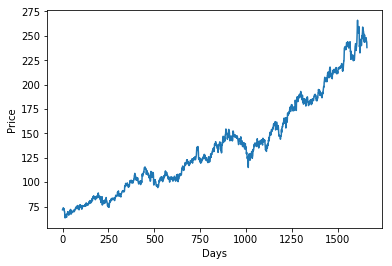

In [7]:
#dates = pd.to_datetime(df['Date'] , format='%Y%m%d')
plt.plot(df['Close'])
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [8]:
batch_size= 128
LR= 0.001
epoch= 1000
input_size= 5
time_steps= 6
sd = 5
n_batch = 128
predmon =120

In [9]:

    
model =Sequential()
model.add(LSTM(
            batch_input_shape=(batch_size,time_steps,input_size),
            output_dim=256,
            return_sequences=True,
            stateful=False,
        ))
model.add(Dropout(0.6))
model.add(LSTM(
        output_dim=128,
            return_sequences=False,
            stateful=False,
         ))
model.add(Dropout(0.6))
model.add(Dense(256))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Dense(2,activation='softmax'))
adam = Adam(LR)

model.compile(optimizer=adam,
                  loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(128, 6, 5..., return_sequences=True, stateful=False, units=256)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, stateful=False, units=128)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (128, 6, 256)             268288    
_________________________________________________________________
dropout_1 (Dropout)          (128, 6, 256)             0         
_________________________________________________________________
lstm_2 (LSTM)                (128, 128)                197120    
_________________________________________________________________
dropout_2 (Dropout)          (128, 128)                0         
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 128)                32896     
__________

In [10]:
start = time.time()
X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test=batch_data(time_steps,-sd,batch_size,predmon,n_batch)
#X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test=batch_data(6,-5,128,120)

start = time.time()

In [12]:
train_history=model.fit(X_t_batch_train, Y_t_batch_train, epochs=2000, batch_size=batch_size,verbose=1 )

Epoch 1/2000
1408/1408 [==============================] - 1s 1ms/step - loss: 0.6798 - acc: 0.5874
Epoch 2/2000
1408/1408 [==============================] - 0s 118us/step - loss: 0.6828 - acc: 0.5767
Epoch 3/2000
1408/1408 [==============================] - 0s 122us/step - loss: 0.6827 - acc: 0.5845
Epoch 4/2000
1408/1408 [==============================] - 0s 115us/step - loss: 0.6830 - acc: 0.5881
Epoch 5/2000
1408/1408 [==============================] - 0s 123us/step - loss: 0.6820 - acc: 0.5824
Epoch 6/2000
1408/1408 [==============================] - 0s 117us/step - loss: 0.6797 - acc: 0.5973
Epoch 7/2000
1408/1408 [==============================] - 0s 92us/step - loss: 0.6737 - acc: 0.5980
Epoch 8/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.6770 - acc: 0.5980
Epoch 9/2000
1408/1408 [==============================] - 0s 115us/step - loss: 0.6768 - acc: 0.5881
Epoch 10/2000
1408/1408 [==============================] - 0s 117us/step - loss: 0.6773 - acc:

1408/1408 [==============================] - 0s 107us/step - loss: 0.6724 - acc: 0.5973
Epoch 161/2000
1408/1408 [==============================] - 0s 104us/step - loss: 0.6702 - acc: 0.6016
Epoch 162/2000
1408/1408 [==============================] - 0s 105us/step - loss: 0.6713 - acc: 0.6058
Epoch 163/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.6705 - acc: 0.5980
Epoch 164/2000
1408/1408 [==============================] - 0s 104us/step - loss: 0.6688 - acc: 0.5987
Epoch 165/2000
1408/1408 [==============================] - 0s 115us/step - loss: 0.6641 - acc: 0.6158
Epoch 166/2000
1408/1408 [==============================] - 0s 109us/step - loss: 0.6670 - acc: 0.6058
Epoch 167/2000
1408/1408 [==============================] - 0s 122us/step - loss: 0.6676 - acc: 0.6087
Epoch 168/2000
1408/1408 [==============================] - 0s 112us/step - loss: 0.6728 - acc: 0.5987
Epoch 169/2000
1408/1408 [==============================] - 0s 122us/step - loss: 0.6748

1408/1408 [==============================] - 0s 105us/step - loss: 0.6474 - acc: 0.6214
Epoch 319/2000
1408/1408 [==============================] - 0s 100us/step - loss: 0.6495 - acc: 0.6222
Epoch 320/2000
1408/1408 [==============================] - 0s 125us/step - loss: 0.6505 - acc: 0.6172
Epoch 321/2000
1408/1408 [==============================] - 0s 109us/step - loss: 0.6461 - acc: 0.6193
Epoch 322/2000
1408/1408 [==============================] - 0s 116us/step - loss: 0.6489 - acc: 0.6243
Epoch 323/2000
1408/1408 [==============================] - 0s 121us/step - loss: 0.6547 - acc: 0.6207
Epoch 324/2000
1408/1408 [==============================] - 0s 106us/step - loss: 0.6513 - acc: 0.6229
Epoch 325/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.6520 - acc: 0.6165
Epoch 326/2000
1408/1408 [==============================] - 0s 114us/step - loss: 0.6550 - acc: 0.6179
Epoch 327/2000
1408/1408 [==============================] - 0s 124us/step - loss: 0.6482 

1408/1408 [==============================] - 0s 105us/step - loss: 0.6470 - acc: 0.6193
Epoch 399/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.6453 - acc: 0.6243
Epoch 400/2000
1408/1408 [==============================] - 0s 104us/step - loss: 0.6433 - acc: 0.6271
Epoch 401/2000
1408/1408 [==============================] - 0s 93us/step - loss: 0.6510 - acc: 0.6236
Epoch 402/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.6477 - acc: 0.6236
Epoch 403/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.6498 - acc: 0.6193
Epoch 404/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.6456 - acc: 0.6243
Epoch 405/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.6444 - acc: 0.6257
Epoch 406/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.6482 - acc: 0.6264
Epoch 407/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.6412 - acc: 

1408/1408 [==============================] - 0s 96us/step - loss: 0.6270 - acc: 0.6342
Epoch 559/2000
1408/1408 [==============================] - 0s 88us/step - loss: 0.6312 - acc: 0.6307
Epoch 560/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.6272 - acc: 0.6278
Epoch 561/2000
1408/1408 [==============================] - 0s 92us/step - loss: 0.6299 - acc: 0.6364
Epoch 562/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.6212 - acc: 0.6371
Epoch 563/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.6254 - acc: 0.6335
Epoch 564/2000
1408/1408 [==============================] - 0s 89us/step - loss: 0.6217 - acc: 0.6300
Epoch 565/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.6220 - acc: 0.6378
Epoch 566/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.6287 - acc: 0.6335
Epoch 567/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.6280 - acc: 0.

1408/1408 [==============================] - 0s 92us/step - loss: 0.6169 - acc: 0.6527
Epoch 719/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.6037 - acc: 0.6555
Epoch 720/2000
1408/1408 [==============================] - 0s 87us/step - loss: 0.6040 - acc: 0.6598
Epoch 721/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.5930 - acc: 0.6570
Epoch 722/2000
1408/1408 [==============================] - 0s 89us/step - loss: 0.6006 - acc: 0.6570
Epoch 723/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.6002 - acc: 0.6541
Epoch 724/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.6023 - acc: 0.6548
Epoch 725/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.5940 - acc: 0.6690
Epoch 726/2000
1408/1408 [==============================] - 0s 92us/step - loss: 0.5946 - acc: 0.6562
Epoch 727/2000
1408/1408 [==============================] - 0s 97us/step - loss: 0.5934 - acc: 0

1408/1408 [==============================] - 0s 98us/step - loss: 0.5352 - acc: 0.7060
Epoch 879/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.5316 - acc: 0.7138
Epoch 880/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.5258 - acc: 0.7166
Epoch 881/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.5215 - acc: 0.7045
Epoch 882/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.5336 - acc: 0.7152
Epoch 883/2000
1408/1408 [==============================] - 0s 88us/step - loss: 0.5256 - acc: 0.7109
Epoch 884/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.5337 - acc: 0.7109
Epoch 885/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.5284 - acc: 0.6996
Epoch 886/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.5243 - acc: 0.7202
Epoch 887/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.5183 - acc:

Epoch 1038/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.4408 - acc: 0.7592
Epoch 1039/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.4344 - acc: 0.7812
Epoch 1040/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.4177 - acc: 0.7805
Epoch 1041/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.4131 - acc: 0.7947
Epoch 1042/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.4261 - acc: 0.7734
Epoch 1043/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.4148 - acc: 0.7912
Epoch 1044/2000
1408/1408 [==============================] - 0s 92us/step - loss: 0.4188 - acc: 0.7756
Epoch 1045/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.4353 - acc: 0.7891
Epoch 1046/2000
1408/1408 [==============================] - 0s 92us/step - loss: 0.4221 - acc: 0.7763
Epoch 1047/2000
1408/1408 [==============================] - 0s 99us/step

1408/1408 [==============================] - 0s 89us/step - loss: 0.3263 - acc: 0.8423
Epoch 1197/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.3378 - acc: 0.8381
Epoch 1198/2000
1408/1408 [==============================] - 0s 93us/step - loss: 0.3222 - acc: 0.8366
Epoch 1199/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.3377 - acc: 0.8402
Epoch 1200/2000
1408/1408 [==============================] - 0s 91us/step - loss: 0.3260 - acc: 0.8324
Epoch 1201/2000
1408/1408 [==============================] - 0s 88us/step - loss: 0.3271 - acc: 0.8445
Epoch 1202/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.3286 - acc: 0.8331
Epoch 1203/2000
1408/1408 [==============================] - 0s 96us/step - loss: 0.3729 - acc: 0.8232
Epoch 1204/2000
1408/1408 [==============================] - 0s 97us/step - loss: 0.3337 - acc: 0.8374
Epoch 1205/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.3225 

1408/1408 [==============================] - 0s 97us/step - loss: 0.2288 - acc: 0.8956
Epoch 1355/2000
1408/1408 [==============================] - 0s 105us/step - loss: 0.2674 - acc: 0.8729
Epoch 1356/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.2646 - acc: 0.8764
Epoch 1357/2000
1408/1408 [==============================] - 0s 82us/step - loss: 0.2646 - acc: 0.8786
Epoch 1358/2000
1408/1408 [==============================] - 0s 86us/step - loss: 0.2409 - acc: 0.8892
Epoch 1359/2000
1408/1408 [==============================] - 0s 89us/step - loss: 0.2501 - acc: 0.8800
Epoch 1360/2000
1408/1408 [==============================] - 0s 89us/step - loss: 0.2679 - acc: 0.8786
Epoch 1361/2000
1408/1408 [==============================] - 0s 93us/step - loss: 0.2715 - acc: 0.8764
Epoch 1362/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.2305 - acc: 0.8928
Epoch 1363/2000
1408/1408 [==============================] - 0s 89us/step - loss: 0.2353

Epoch 1512/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.1868 - acc: 0.9169
Epoch 1513/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.1929 - acc: 0.9070
Epoch 1514/2000
1408/1408 [==============================] - 0s 97us/step - loss: 0.1756 - acc: 0.9134
Epoch 1515/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.1752 - acc: 0.9183
Epoch 1516/2000
1408/1408 [==============================] - 0s 109us/step - loss: 0.1685 - acc: 0.9290
Epoch 1517/2000
1408/1408 [==============================] - 0s 104us/step - loss: 0.1658 - acc: 0.9205
Epoch 1518/2000
1408/1408 [==============================] - 0s 115us/step - loss: 0.1993 - acc: 0.9105
Epoch 1519/2000
1408/1408 [==============================] - 0s 110us/step - loss: 0.2159 - acc: 0.9020
Epoch 1520/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.1955 - acc: 0.9162
Epoch 1521/2000
1408/1408 [==============================] - 0s 99

Epoch 1591/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.1341 - acc: 0.9375
Epoch 1592/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.1249 - acc: 0.9545
Epoch 1593/2000
1408/1408 [==============================] - 0s 98us/step - loss: 0.1237 - acc: 0.9432
Epoch 1594/2000
1408/1408 [==============================] - 0s 97us/step - loss: 0.1351 - acc: 0.9361
Epoch 1595/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.1542 - acc: 0.9375
Epoch 1596/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.1550 - acc: 0.9347
Epoch 1597/2000
1408/1408 [==============================] - 0s 104us/step - loss: 0.1730 - acc: 0.9268
Epoch 1598/2000
1408/1408 [==============================] - 0s 94us/step - loss: 0.1626 - acc: 0.9240
Epoch 1599/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.1426 - acc: 0.9396
Epoch 1600/2000
1408/1408 [==============================] - 0s 100us

1408/1408 [==============================] - 0s 98us/step - loss: 0.1111 - acc: 0.9553
Epoch 1671/2000
1408/1408 [==============================] - 0s 108us/step - loss: 0.1530 - acc: 0.9411
Epoch 1672/2000
1408/1408 [==============================] - 0s 101us/step - loss: 0.1478 - acc: 0.9403
Epoch 1673/2000
1408/1408 [==============================] - 0s 90us/step - loss: 0.1425 - acc: 0.9432
Epoch 1674/2000
1408/1408 [==============================] - 0s 106us/step - loss: 0.1367 - acc: 0.9361
Epoch 1675/2000
1408/1408 [==============================] - 0s 116us/step - loss: 0.1284 - acc: 0.9517
Epoch 1676/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.1142 - acc: 0.9553
Epoch 1677/2000
1408/1408 [==============================] - 0s 100us/step - loss: 0.1803 - acc: 0.9318
Epoch 1678/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.1651 - acc: 0.9432
Epoch 1679/2000
1408/1408 [==============================] - 0s 93us/step - loss: 

1408/1408 [==============================] - 0s 106us/step - loss: 0.1359 - acc: 0.9474
Epoch 1750/2000
1408/1408 [==============================] - 0s 95us/step - loss: 0.1069 - acc: 0.9545
Epoch 1751/2000
1408/1408 [==============================] - 0s 103us/step - loss: 0.1256 - acc: 0.9517
Epoch 1752/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.1047 - acc: 0.9602
Epoch 1753/2000
1408/1408 [==============================] - 0s 99us/step - loss: 0.0980 - acc: 0.9616
Epoch 1754/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.1236 - acc: 0.9567
Epoch 1755/2000
1408/1408 [==============================] - 0s 106us/step - loss: 0.1377 - acc: 0.9446
Epoch 1756/2000
1408/1408 [==============================] - 0s 100us/step - loss: 0.1242 - acc: 0.9553
Epoch 1757/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.0986 - acc: 0.9581
Epoch 1758/2000
1408/1408 [==============================] - 0s 97us/step - loss: 

Epoch 1907/2000
1408/1408 [==============================] - 0s 108us/step - loss: 0.0680 - acc: 0.9730
Epoch 1908/2000
1408/1408 [==============================] - 0s 106us/step - loss: 0.0725 - acc: 0.9730
Epoch 1909/2000
1408/1408 [==============================] - 0s 107us/step - loss: 0.0568 - acc: 0.9808
Epoch 1910/2000
1408/1408 [==============================] - 0s 108us/step - loss: 0.0658 - acc: 0.9730
Epoch 1911/2000
1408/1408 [==============================] - 0s 102us/step - loss: 0.0715 - acc: 0.9673
Epoch 1912/2000
1408/1408 [==============================] - 0s 110us/step - loss: 0.0640 - acc: 0.9737
Epoch 1913/2000
1408/1408 [==============================] - 0s 108us/step - loss: 0.0749 - acc: 0.9709
Epoch 1914/2000
1408/1408 [==============================] - 0s 108us/step - loss: 0.0721 - acc: 0.9688
Epoch 1915/2000
1408/1408 [==============================] - 0s 110us/step - loss: 0.0566 - acc: 0.9773
Epoch 1916/2000
1408/1408 [==============================] - 0s 

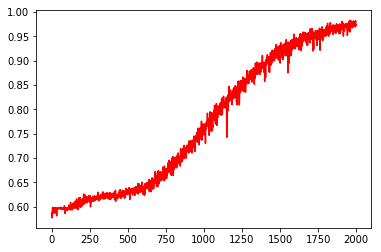

In [13]:
plt.plot(train_history.history['acc'],color='red')
plt.show()

In [14]:
#https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/


# re-define the batch size
#n_batch = 30

# time_steps = 14
# input_size = 8
# re-define model.history['val_acc']
new_model = Sequential()

new_model.add(LSTM(
        batch_input_shape=(n_batch,time_steps,input_size),
        output_dim=256,
        return_sequences=True,
        stateful=False,
    ))
new_model.add(Dropout(0.6))
new_model.add(LSTM(
        output_dim=128,
        return_sequences=False,
        stateful=False,
     ))
new_model.add(Dropout(0.6))
new_model.add(Dense(256))
new_model.add(Dropout(0.4))
new_model.add(Dense(128))
new_model.add(Dropout(0.4))
new_model.add(Dense(64))
new_model.add(Dropout(0.4))
new_model.add(Dense(2,activation='softmax'))
adam = Adam(LR)

model.compile(optimizer=adam,
                  loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

new_model.compile(optimizer=adam,
                  loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(128, 6, 5..., return_sequences=True, stateful=False, units=256)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, stateful=False, units=128)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (128, 6, 256)             268288    
_________________________________________________________________
dropout_1 (Dropout)          (128, 6, 256)             0         
_________________________________________________________________
lstm_2 (LSTM)                (128, 128)                197120    
_________________________________________________________________
dropout_2 (Dropout)          (128, 128)                0         
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 128)                32896     
__________

In [22]:
yhat = new_model.predict_classes(X_t_batch_test, batch_size=n_batch)
#print(yhat.shape)
# print('predict yhat is:',yhat[:])


# print('actual  y    is:',Y_t_batch_test[:,1].astype(int))

# print('the correct amount is ',np.sum(yhat[:] == Y_t_batch_test[:,1]))
# print('the correct rate is ',round(np.sum(yhat[:] == Y_t_batch_test[:,1])/n_batch,4)*100,'%')

AttributeError: 'list' object has no attribute 'shape'

In [16]:
plt.plot(yhat,color='red')
#plt.plot(train_history.history['val_acc'],color='red')
plt.show()

NameError: name 'yhat' is not defined